In [37]:
import nbformat
from pathlib import Path
import re
from datetime import datetime
from matplotlib import pyplot as plt
import statistics
import itertools
import json

In [38]:
names_map = {
    'notebooks/sanket7994/imdb-dataset-eda-project/bench.ipynb': 'imdb',
    'notebooks/madhurpant/beautiful-kaggle-2022-analysis/bench.ipynb': 'mad-kaggle',
    'notebooks/sandhyakrishnan02/indian-startup-growth-analysis/bench.ipynb': 'startups',
    'notebooks/nickwan/creating-player-stats-using-tracking-data/bench.ipynb': 'player-stats',
    'notebooks/kkhandekar/environmental-vs-ai-startups-india-eda/bench.ipynb': 'india-startups',
    'notebooks/josecode1/bench.ipynb': 'billionaires',
    'notebooks/pmarcelino/comprehensive-data-exploration-with-python/bench.ipynb': 'data-exploration',
    'notebooks/roopacalistus/retail-supermarket-store-analysis/bench.ipynb': 'supermarket-analysis',
    'notebooks/gksriharsha/eda-speedtests/bench.ipynb': 'speedtests',
    'notebooks/saisandeepjallepalli/adidas-retail-eda-data-visualization/bench.ipynb': 'adidas',
    'notebooks/spscientist/student-performance-in-exams/bench.ipynb': 'exams',
    'notebooks/aieducation/what-course-are-you-going-to-take/bench.ipynb': 'course',
    'notebooks/dataranch/supermarket-sales-prediction-xgboost-fastai/bench.ipynb': 'supermarket-prediction',
    'notebooks/lextoumbourou/feedback3-eda-hf-custom-trainer-sift/bench.ipynb': 'feedback3',
    'notebooks/ampiiere/animal-crossing-villager-popularity-analysis/bench.ipynb': 'animal-crossing',
    'notebooks/mpwolke/just-you-wait-rishi-sunak/bench.ipynb': 'sunak',
    'notebooks/erikbruin/nlp-on-student-writing-eda/bench.ipynb': 'nlp-writing',
    'notebooks/ibtesama/getting-started-with-a-movie-recommendation-system/bench.ipynb': 'movie-rec',
    'notebooks/joshuaswords/netflix-data-visualization/bench.ipynb': 'netflix-viz'
}

In [39]:
notebook_dir = Path('notebooks')

In [40]:
def extract_elapsed_time(text):
    pattern = r'Total elapsed time: (\d+\.\d+)'
    match = re.search(pattern, text)
    if match:
        return float(match.group(1))
    else:
        return None


In [41]:
def extract_and_convert_time(text):
    pattern = r'time: (\d+(?:\.\d+)?)\s+(µs|ms|s)'  # Match time in seconds, milliseconds, or microseconds
    match = re.search(pattern, text)
    if match:
        # print("MATCH", match.group(1))
        # print(match.group(2))
        time_str = match.group(1)
        # time_unit = text[match.end():match.end() + 2]  # Get the time unit (µs, ms, or s)

        time_unit = match.group(2)
        time_in_ms = convert_to_milliseconds(float(time_str), time_unit)
        return time_in_ms
    else:
        return None

def convert_to_milliseconds(time_value, time_unit):
    if time_unit == "µs":
        return time_value / 1000  # Convert microseconds to milliseconds
    elif time_unit == "ms":
        return time_value  # Time is already in milliseconds
    elif time_unit == "s":
        return time_value * 1000  # Convert seconds to milliseconds
    else:
        return None

In [42]:
def extract_and_convert_time(text):
    pattern = r'time: (\d+min\s*)?(\d+(?:\.\d+)?)\s*(µs|ms|s)'
    match = re.search(pattern, text)
    # print(match)
    if match:
        minutes = match.group(1)
        time_str = match.group(2)
        time_unit = match.group(3)
        time_in_ms = convert_to_milliseconds(float(time_str), time_unit, minutes)
        return time_in_ms
    else:
        return None

def convert_to_milliseconds(time_value, time_unit, minutes):
    if minutes is not None:
        minute_val = float(minutes.replace("min", '').strip()) * 60000
    else:
        minute_val = 0
    if time_unit == "µs":
        return (time_value / 1000) + minute_val  # Convert microseconds to milliseconds
    elif time_unit == "ms":
        return (time_value) + minute_val  # Time is already in milliseconds
    elif time_unit == "s":
        return (time_value * 1000) + minute_val  # Convert seconds to milliseconds
    else:
        return None


In [43]:
print(extract_and_convert_time("time: 8min 18s (started: 2024-05-07 16:37:48 -04:00)"))

498000.0


In [44]:
times_path = Path('times.json')
if not times_path.exists():
    notebooks = {}
    for fpath in notebook_dir.glob("**/*.ipynb"):
        with open(fpath, 'r') as f:
            notebooks[str(fpath)] = nbformat.read(f, as_version=4)
 
    for nbfile in notebooks:
        cell = ([c for c in notebooks[nbfile]['cells'] if c['cell_type'] == 'code'][-1])
        # print(cell['outputs'])
        try:
            if 'Total elapsed' not in (next(c for c in cell['outputs'] if 'name' in c and c['name'] == 'stdout')['text']):
                print(nbfile)
                print(cell)
        except:
            print(nbfile)
            continue
    elapsed_times = {}
    for nbfile in notebooks:
        cell = ([c for c in notebooks[nbfile]['cells'] if c['cell_type'] == 'code'][-1])
        try:
            time_output = (next(c for c in cell['outputs'] if 'name' in c and c['name'] == 'stdout')['text'])
        except StopIteration:
            continue
        elapsed_time = extract_elapsed_time(time_output)
        assert elapsed_time is not None
        elapsed_times[nbfile] = elapsed_time

    outer_cell_times = {}
    for nbfile,nb in notebooks.items():
        cell_times = []
        for cell in nb['cells']:
            if cell['cell_type'] != 'code':
                continue
            try:
                time_output = (next(c for c in cell['outputs'][::-1] if 'name' in c and c['name'] == 'stdout' and 'text' in c and 'time:' in c['text'])['text'])
            except StopIteration:
                continue
            # print(time_output)
            x = extract_and_convert_time(time_output)
            if x is None:
                print("bad",nbfile, time_output)
            # else:
            #     print("good", time_output)
            cell_times.append(x)
        # print(cell_times)
        outer_cell_times[nbfile] = cell_times
else:
    with open(times_path, 'r') as f:
        times = json.load(f)
        outer_cell_times = times['outer_cell_times']
        elapsed_times = times['elapsed_times']
        notebooks = dict.fromkeys(outer_cell_times.keys())

In [45]:
notebook_names_orig = [k for k in notebooks.keys() if k in elapsed_times]
notebook_names = sorted(notebook_names_orig, key=lambda n : elapsed_times[n])

In [46]:
notebooks_sorted_by_cell = sorted(notebook_names_orig, key=lambda n : max(outer_cell_times[n]), reverse=True)
print('\n'.join([' '.join((n, str(max(outer_cell_times[n])))) for n in notebooks_sorted_by_cell[:10]]))

notebooks/joshuaswords/netflix-data-visualization/bench.ipynb 498000.0
notebooks/ibtesama/getting-started-with-a-movie-recommendation-system/bench.ipynb 282000.0
notebooks/mpwolke/just-you-wait-rishi-sunak/bench.ipynb 70000.0
notebooks/erikbruin/nlp-on-student-writing-eda/bench.ipynb 58800.0
notebooks/ampiiere/animal-crossing-villager-popularity-analysis/bench.ipynb 31300.0
notebooks/lextoumbourou/feedback3-eda-hf-custom-trainer-sift/bench.ipynb 22700.0
notebooks/dataranch/supermarket-sales-prediction-xgboost-fastai/bench.ipynb 13500.0
notebooks/spscientist/student-performance-in-exams/bench.ipynb 6640.0
notebooks/aieducation/what-course-are-you-going-to-take/bench.ipynb 4030.0000000000005
notebooks/gksriharsha/eda-speedtests/bench.ipynb 3190.0


In [47]:
[k for k in notebooks.keys() if not k in notebook_names]

['notebooks/paultimothymooney/kaggle-survey-2022-all-results/bench.ipynb',
 'notebooks/erikbruin/nlp-on-student-writing-eda/Untitled.ipynb']

In [48]:
def plot(categories, values, title, xtitle, ytitle):
    plt.figure()
    plt.bar(categories, values)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

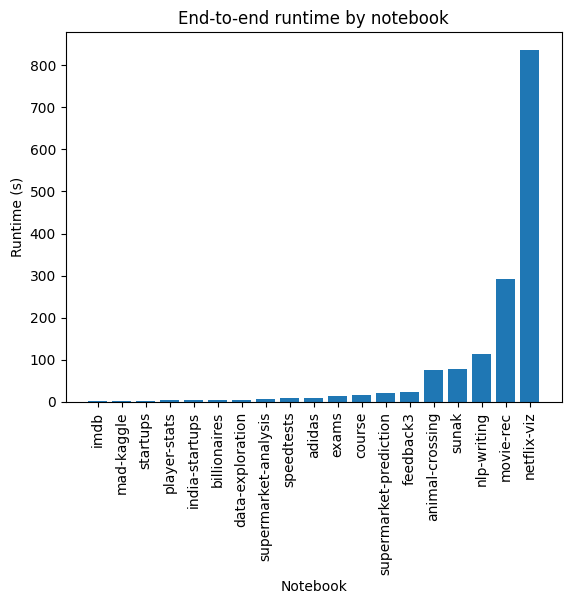

In [49]:
categories = [names_map[n] for n in notebook_names]
total_times = [elapsed_times[n] for n in notebook_names]
plot(categories, total_times, "End-to-end runtime by notebook", 'Notebook', 'Runtime (s)')

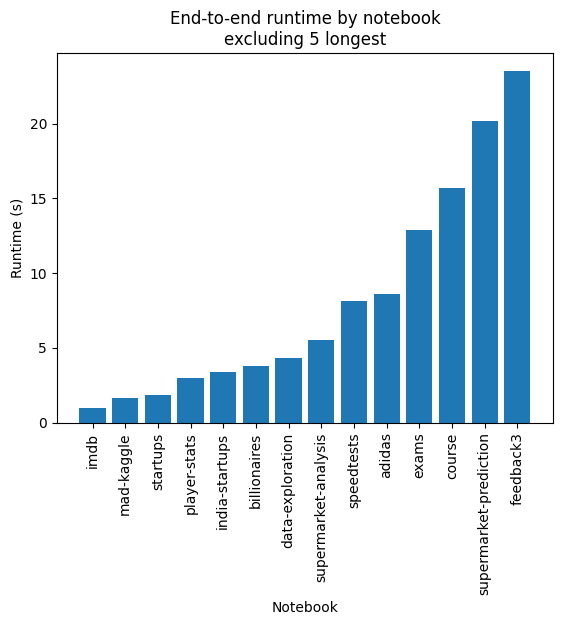

In [50]:
categories = [names_map[n] for n in notebook_names][:-5]
total_times = [elapsed_times[n] for n in notebook_names][:-5]
plot(categories, total_times, "End-to-end runtime by notebook\nexcluding 5 longest", 'Notebook', 'Runtime (s)')

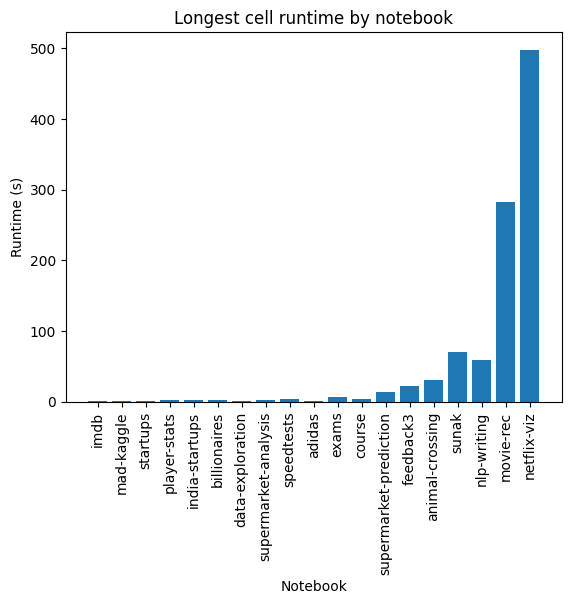

In [51]:
categories = [names_map[n] for n in notebook_names]
max_cell_times = [max(outer_cell_times[n]) / 10 ** 3 for n in notebook_names]
plot(categories, max_cell_times, "Longest cell runtime by notebook", 'Notebook', 'Runtime (s)')

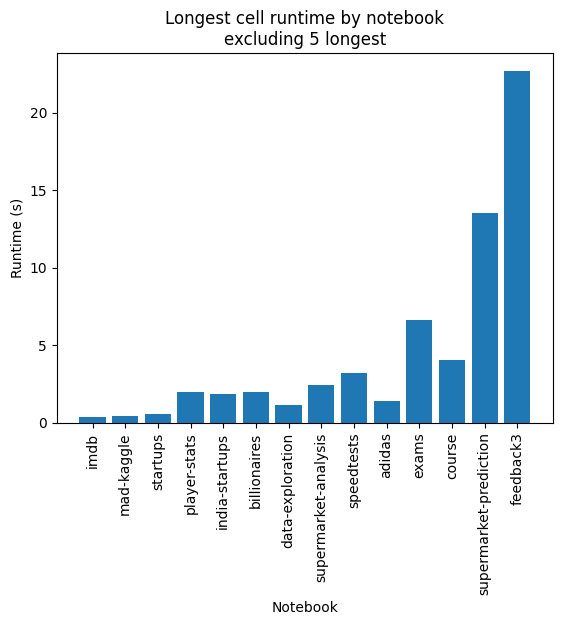

In [52]:
categories = [names_map[n] for n in notebook_names][:-5]
max_cell_times = [max(outer_cell_times[n]) / 10 ** 3 for n in notebook_names][:-5]
plot(categories, max_cell_times, "Longest cell runtime by notebook\nexcluding 5 longest", 'Notebook', 'Runtime (s)')

[1020.0, 1080.0, 1120.0, 1130.0, 1150.0, 1170.0, 1190.0, 1310.0, 1430.0, 1440.0, 1460.0, 1680.0, 1720.0, 1840.0, 1880.0, 1950.0, 1970.0, 2009.9999999999998, 2100.0, 2310.0, 2310.0, 2380.0, 2410.0, 2480.0, 2600.0, 2620.0, 2630.0, 2770.0, 3120.0, 3190.0, 3500.0, 3570.0, 4030.0000000000005, 4190.0, 4190.0, 4270.0, 4340.0, 4740.0, 5210.0, 5430.0, 5960.0, 6640.0, 8350.0, 9740.0, 9890.0]


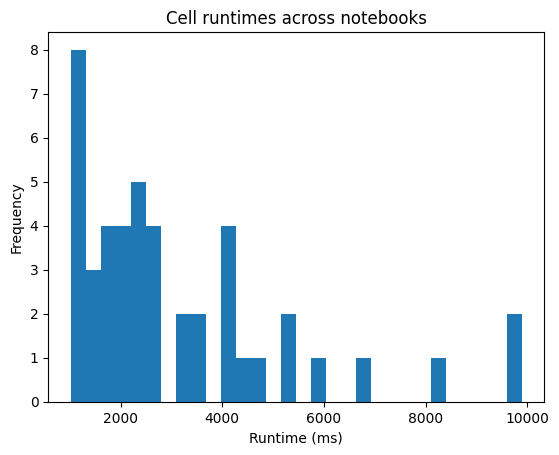

In [53]:
cell_times_flat = [c for c in itertools.chain.from_iterable(outer_cell_times.values()) if c >= 1000 and c <= 10000]
print(sorted(cell_times_flat))
plt.figure()
plt.hist(cell_times_flat, bins=30)
plt.title("Cell runtimes across notebooks")
plt.xlabel("Runtime (ms)")
plt.ylabel("Frequency")
plt.show()

In [54]:
list(cell_times_flat)

[1020.0,
 1430.0,
 1170.0,
 2100.0,
 1970.0,
 1840.0,
 1120.0,
 5960.0,
 3500.0,
 1130.0,
 2770.0,
 3570.0,
 1150.0,
 2380.0,
 3190.0,
 4740.0,
 2310.0,
 2310.0,
 4030.0000000000005,
 1950.0,
 3120.0,
 1720.0,
 1680.0,
 1190.0,
 2410.0,
 1880.0,
 1080.0,
 6640.0,
 5430.0,
 2480.0,
 8350.0,
 1460.0,
 4340.0,
 2630.0,
 2620.0,
 1440.0,
 2600.0,
 4270.0,
 5210.0,
 4190.0,
 4190.0,
 2009.9999999999998,
 9890.0,
 1310.0,
 9740.0]